**Setup**

In [22]:
# Module Imports
from openai import OpenAI
import os, docx, pdfplumber, subprocess

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage # User Input and System Prompt

from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langsmith import traceable
from langsmith import utils

# ReWOO Imports
from typing import List
from typing_extensions import TypedDict, Dict, Any 
import re
from langchain_core.prompts import ChatPromptTemplate

In [2]:
utils.get_env_var.cache_clear()

In [3]:
# Load .env File
%load_ext dotenv
%dotenv

In [4]:
# OpenAI API & Key
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
llm = ChatOpenAI(model="gpt-4o")

*ReWOO Setup*

In [5]:
class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

In [6]:
planner_prompt = """
    For the following task, make plans that can solve the problem step by step. For each plan,
    indicate:

    Which external tool together with tool input to retreive evidence. You can store the evidence into a:
        variable #E that can be called by later tools. (Plan, #E1, Plan, #2, Plan, ...)
        Plan: Explain the plan
        #E1 = TOOL[tool-input]
        Plan: Explain the plan for the next step
        #E2 = TOOL[tool-input]

    Allowed TOOLS:
    1) LLM[input] - Let the language model reason
    2) CV[input] - The tool extract_cv_text, input = local path
    3) JobPost[input] - The tool job_posting_tool, input a job url

    Do not invest any other tool names.
    Begin!

    Task: {task} 
"""

In [7]:
task = """
    look into my cv called 'Garrett Audet - Resume.pdf' can you evaluate it
    and how would it perform on this posting: https://ca.linkedin.com/jobs/view/canada-gtm-strategy-operations-lead-at-square-4286742601

"""

result = llm.invoke(planner_prompt.format(task=task))
print(result.content)

Plan: Start by extracting and analyzing the details of the job posting from the given URL to understand the requirements and expectations of the role.

#E1 = JobPost[https://ca.linkedin.com/jobs/view/canada-gtm-strategy-operations-lead-at-square-4286742601]

Plan: Use the CV tool to extract the text from the provided CV PDF file to analyze Garrett Audet's qualifications and experiences.

#E2 = CV[Garrett Audet - Resume.pdf]

Plan: Analyze and compare the details from the job posting (#E1) and the extracted CV text (#E2) to evaluate how well Garrett Audet's skills and experiences align with the job requirements.

#E3 = LLM[Use #E1 and #E2 to evaluate how Garrett Audet's CV matches the job requirements, and suggest areas for improvement.]

Plan: Present the evaluation result from the LLM analysis, detailing the strengths and weaknesses of Garrett Audet’s CV in relation to the job posting.

#E4 = LLM[Summarize the findings from #E3 to provide a clear evaluation report.]


In [8]:
# Regex to extract plan
plan_regex=r"Plan:\s*(.+?)\s*(#E\d+)\s*=\s*(\w+)\[(.+?)\]"

In [9]:
@traceable(names="Planner Node")
def planner_node(state: ReWOO):
    task = state["task"]
    raw_plan = llm.invoke(planner_prompt.format(task=task)).content
    steps = re.findall(plan_regex, raw_plan, flags=re.S)
    return {"plan_string": raw_plan, "steps": steps}

*Tools*

In [10]:
# Tool to Extract CV
@tool 
def extract_cv_text(file_path: str) -> str:
    """
        Extracts the text components from a CV file in PDF, DocX, or DOC format. The CV should be inside the
        same folder that this notebook is in. 

        Args:
            file_path (str): The local file path to the CV Document.

        Returns:
            str: The extracted plain text from the CV, or an error message if the format is unsupported or cannot be read. 
    """
    ext = os.path.splitext(file_path)[-1].lower()

    if ".docx" in ext:
        try:
            doc = docx.Document(file_path)
            text = [para.text for para in doc.paragraphs] 
            return '\n'.join(text)
        except Exception as e:
            return f"Error reading the .doc file: {e}"

    elif ".pdf" in ext:
        try:
            text = []
            with pdfplumber.open(file_path) as pdf:
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text.append(page_text)
            return '\n'.join(text)
        except Exception as e:
            return f"Error reading the .pdf file: {e}"

    elif ".doc" in ext:
        try:
            temp_docx = file_path + ".temp.docx"
            subprocess.run(['soffice','--headless','--convert-to', 'docx', '--outdir', os.path.dirname(file_path), file_path],check=True)
            doc = docx.Document(os.path.splitext(file_path)[0] + '.docx')
            text = [para.text for para in doc.paragraphs]

            os.remove(os.path.splitext(file_path)[0]+".docx")
            return '\n'.join(text)
        except Exception as e:
            return f"Error reading .doc file: {e}"

    else:
        return "Unsupported file format! Please use .pdf, .docx, or .doc."

In [11]:
# Tool to Webscrape Job Posting
@tool
def job_posting_tool(job_link: str) -> str:
    """
    Extracts structured information from a job posting at the provided URL.

    Args:
        job_link (str): The URL of the job posting

    Returns:
        str: A structured summary of the job posting's key details.
    """
    completion = client.chat.completions.create(
        model="gpt-4o-search-preview",
        web_search_options={"search_context_size": "medium"},
        messages=[
            {
                "role": "user",
                "content": """
                        You are a helpful tool that visits the following job post and carefully reads its content.
                        Summarize the key details in a clear and concise format, including:
                        Visit the provided job posting link, read it thoroughly, and extract and summarize all key information. Include:
                        - Job Title
                        - Company Name
                        - Location
                        - Employment Type (Full-time, part-time, contract, etc.)
                        - Salary or Compensation (if available) 
                        - Required Qualifications/Skills
                        - Primary Responsibilities
                        - Benefits Offered
                        - Application Instructions
                        - Posting Date (if available)
        
                        Format:
                        - Respond with a clear, structured bullet-point list
                        - Use exact factual information from the posting, no rewording beyond making it concise.
                        - If the posting is missing, inaccessible, or contains no job details, respond with:
                        "job posting unavailable or contains no job details." 
        
                        Do's
                        - Ensure all extracted details are accurate and directly taken from the posting 
                        - Keep description short, professional, and easy to scan
                        - Use consistent formatting for all fields (e.g., "Job title: ...")
                        Dont's
                        - Do not include filler language, speculation, or personal opinions
                        - Do not rewrite or interpret details-only report factual information from the posting
                        """,
            },
            {
                "role": "user",
                "content": f"visit this job posting and extract details:\n{job_link}",
            },
        ],
    )

    return completion.choices[0].message.content

*Binding Tools to LLM*

In [12]:
tools = [job_posting_tool, extract_cv_text]

In [13]:
def _current_index(state: ReWOO):
    done = len(state.get("results",{}))
    total = len(state['steps'])
    return None if done >= total else done

In [14]:
@traceable(name="Executer Node")
def executor_node(state: ReWOO):
    # Identifies current step
    idx = _current_index(state)
    if idx is None:
        return {}

    # Extracts the step's components 
    plan_text, step_name, tool_name, tool_input = state["steps"][idx]
    for k, v in state.get("results", {}).items():
        if tool_name == "LLM" and k in tool_input:
            tool_input=tool_input.replace(k,v)

    # Executes the appropriate tool
    if tool_name == "LLM":
        out = llm.invoke(tool_input).content
    elif tool_name == "CV":
        out = extract_cv_text.invoke(tool_input)
    elif tool_name == "JobPost":
        out = job_posting_tool.invoke(tool_input)
    else:
        raise ValueError(f"Unknown tool {tool_name}")

    # Saves the tool's output to the state
    results = dict(state.get("results", {}))
    results[step_name] = str(out)
    return {"results": results}

In [15]:
solver_prompt = """
solve the following task or problem. To solve the problem, we have made a step-by-step Plan and 
retrieved corresponding evidence to each Plan. Use them with caution since long evidence might
contain irrelevant information.

{plan_block}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:

"""

In [16]:
@traceable(name="Solver Node")
def solver_node(state: ReWOO):
    lines = []
    for plan_text, step_name, tool_name, tool_input in state["steps"]:
        evidence = state["results"][step_name]
        lines.append(f"Plan: {plan_text}\nEvidence {step_name}: {evidence}\n")
    prompt = solver_promp.format(plan_blocks="\n".join(lines),task=state["task"])
    answer = llm.invoke(prompt).content.strip()
    return {'result':answer}

In [17]:
def router(state: ReWOO):
    return "solve" if _current_index(state) is None else "tool"

In [18]:
llm_with_tools = llm.bind_tools(tools)

*Building a Graph System*

In [23]:
# Short Term Memory
builder = StateGraph(ReWOO)

builder.add_node("plan", planner_node)
builder.add_node("tool", executor_node)
builder.add_node("solve", solver_node)

builder.set_entry_point("plan")
builder.add_edge("plan", "tool")
builder.add_conditional_edges("tool", router)
builder.add_edge("solve", END)

react_graph = builder.compile()

*System Visual*

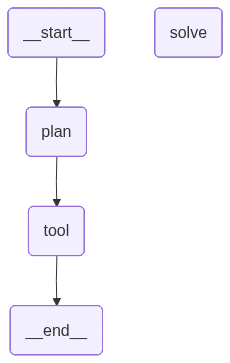

In [24]:
react_graph

*Evaluation*